# Learning Objectives

- Create a Chroma vector database by chunking and indexing a large document
- Given a user query, use similarity search to extract relevant portions of the document from the vector database   

Note: Open-source embedding models could also be directly used to create embeddings for input text (instead of using the Anyscale API). However, they run efficiently only on a GPU. To illustrate this method of using open-source models, we use a T4 GPU runtime in this notebook. In this notebook, we download and use the `gte-large` model instead sending API requests to Anyscale.

In [ ]:
!pip install -q openai==1.23.2 \
                tiktoken==0.6.0 \
                pypdf==4.0.1 \
                chromadb==0.4.22 \
                langchain==0.1.9 \
                langchain-community==0.0.32 \
                sentence-transformers==2.3.1

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

from langchain_community.document_loaders import PyPDFLoader
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from langchain_community.vectorstores import Chroma

from google.colab import drive

In [ ]:
embedding_model_name = 'thenlper/gte-large'

In [ ]:
embedding_model = SentenceTransformerEmbeddings(model_name=embedding_model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

# Chunking

To chunk the document, we use the tokenizer from Open AI that is available in the `tiktoken` package.

In [ ]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    encoding_name='cl100k_base',
    chunk_size=512,
    chunk_overlap=16
)

In [ ]:
pdf_file_location = '/content/tsla-20231231-gen.pdf'

In [ ]:
pdf_loader = PyPDFLoader(pdf_file_location)

In [ ]:
tesla_10k_chunks_ada = pdf_loader.load_and_split(text_splitter)

In [ ]:
len(tesla_10k_chunks_ada)

351

In [ ]:
type(tesla_10k_chunks_ada)

list

In [ ]:
tesla_10k_chunks_ada[0].page_content

'UNITED\tSTATES\nSECURITIES\tAND\tEXCHANGE\tCOMMISSION\nWashington,\tD.C.\t20549\nFORM\t\n10-K\n(Mark\tOne)\nx\nANNUAL\tREPORT\tPURSUANT\tTO\tSECTION\t13\tOR\t15(d)\tOF\tTHE\tSECURITIES\tEXCHANGE\tACT\tOF\t1934\nFor\tthe\tfiscal\tyear\tended\t\nDecember\t31\n,\t2023\nOR\no\nTRANSITION\tREPORT\tPURSUANT\tTO\tSECTION\t13\tOR\t15(d)\tOF\tTHE\tSECURITIES\tEXCHANGE\tACT\tOF\t1934\nFor\tthe\ttransition\tperiod\tfrom\t_________\tto\t_________\nCommission\tFile\tNumber:\t\n001-34756\nTesla,\tInc.\n(Exact\tname\tof\tregistrant\tas\tspecified\tin\tits\tcharter)\nDelaware\n91-2197729\n(State\tor\tother\tjurisdiction\tof\nincorporation\tor\torganization)\n(I.R.S.\tEmployer\nIdentification\tNo.)\n1\tTesla\tRoad\nAustin\n,\t\nTexas\n78725\n(Address\tof\tprincipal\texecutive\toffices)\n(Zip\tCode)\n(\n512\n)\t\n516-8177\n(Registrant’s\ttelephone\tnumber,\tincluding\tarea\tcode)\nSecurities\tregistered\tpursuant\tto\tSection\t12(b)\tof\tthe\tAct:\nTitle\tof\teach\tclass\nTrading\tSymbol(s)\nName\tof\t

# Indexing to Chroma

In [ ]:
tesla_10k_collection = 'tesla-10k-2023'

In [ ]:
vectorstore = Chroma.from_documents(
    tesla_10k_chunks_ada,
    embedding_model,
    collection_name=tesla_10k_collection,
    persist_directory='./tesla2023_db'
)

# Query

In [ ]:
query = "Summarize the management analysis and discussion section in 4 sentences?"

In [ ]:
docs = vectorstore.similarity_search(query, k=2)

In [ ]:
for i, doc in enumerate(docs):
    print(f"Retrieved chunk {i}: \n")
    print(doc.page_content.replace('\t', ' '))
    print('\n')

Retrieved chunk 0: 

ITEM 7. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS
The following discussion and analysis should be read in conjunction with the consolidated financial statements and the related notes included
elsewhere in this Annual Report on Form 10-K. For further discussion of our products and services, technology and competitive strengths, refer to Item 1-
Business. For discussion related to changes in financial condition and the results of operations for fiscal year 2022-related items, refer to Part II, Item 7.
Management’s Discussion and Analysis of Financial Condition and Results of Operations in our Annual Report on Form 10-K for fiscal year 2022, which was
filed with the Securities and Exchange Commission on January 31, 2023.
Overview and 2023 Highlights
Our mission is to accelerate the world’s transition to sustainable energy. We design, develop, manufacture, lease and sell high-performance fully
electric vehicles, solar energy 

# Persist Database to Disk

In [ ]:
vectorstore.persist()

In [ ]:
vectorstore_persisted = Chroma(
    collection_name=tesla_10k_collection,
    persist_directory='./tesla2023_db',
    embedding_function=embedding_model
)

In [ ]:
docs = vectorstore_persisted.similarity_search(query, k=2)

In [ ]:
for i, doc in enumerate(docs):
    print(f"Retrieved chunk {i}: \n")
    print(doc.page_content.replace('\t', ' '))
    print('\n')

Retrieved chunk 0: 

ITEM 7. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS
The following discussion and analysis should be read in conjunction with the consolidated financial statements and the related notes included
elsewhere in this Annual Report on Form 10-K. For further discussion of our products and services, technology and competitive strengths, refer to Item 1-
Business. For discussion related to changes in financial condition and the results of operations for fiscal year 2022-related items, refer to Part II, Item 7.
Management’s Discussion and Analysis of Financial Condition and Results of Operations in our Annual Report on Form 10-K for fiscal year 2022, which was
filed with the Securities and Exchange Commission on January 31, 2023.
Overview and 2023 Highlights
Our mission is to accelerate the world’s transition to sustainable energy. We design, develop, manufacture, lease and sell high-performance fully
electric vehicles, solar energy 

# Save Database State to Google Drive

Using a GPU to create an index is the most compute intensive portion of operating a vector database. While we have persisted the database to the local Colab instance in the previous section, this folder is lost once the notebook is disconnected. To avoid losing data, we can copy the database state from the notebook to Google Drive for later reuse.

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r tesla2023_db /content/drive/MyDrive

The above code saves the database state to Google Drive (within My Drive).

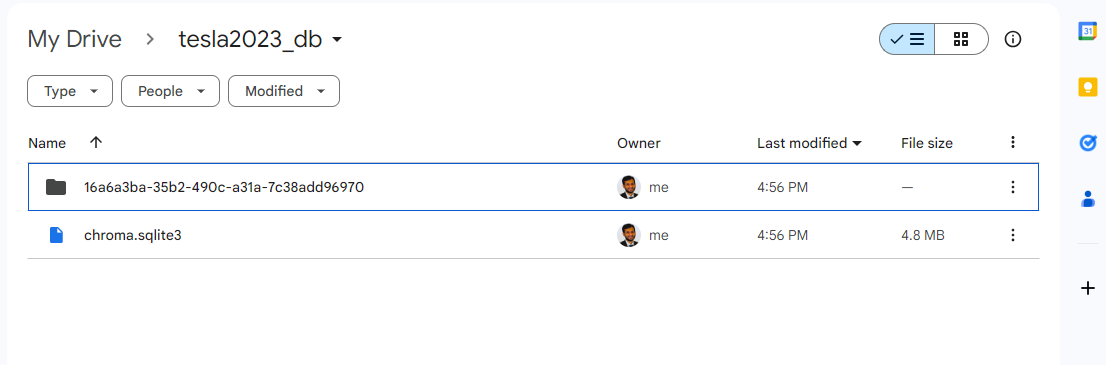

Now this folder can be downloaded into the Colab instance as needed like so:

In [ ]:
persisted_vectordb_location = '/content/drive/MyDrive/tesla2023_db'

In [ ]:
vectorstore_persisted = Chroma(
    collection_name=tesla_10k_collection,
    persist_directory=persisted_vectordb_location,
    embedding_function=embedding_model
)

We can now run the similarity search as before, but the database is hosted and streamed from Google Drive.

In [ ]:
docs = vectorstore_persisted.similarity_search(query, k=2)

In [ ]:
for i, doc in enumerate(docs):
    print(f"Retrieved chunk {i}: \n")
    print(doc.page_content.replace('\t', ' '))
    print('\n')

Retrieved chunk 0: 

ITEM 7. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS
The following discussion and analysis should be read in conjunction with the consolidated financial statements and the related notes included
elsewhere in this Annual Report on Form 10-K. For further discussion of our products and services, technology and competitive strengths, refer to Item 1-
Business. For discussion related to changes in financial condition and the results of operations for fiscal year 2022-related items, refer to Part II, Item 7.
Management’s Discussion and Analysis of Financial Condition and Results of Operations in our Annual Report on Form 10-K for fiscal year 2022, which was
filed with the Securities and Exchange Commission on January 31, 2023.
Overview and 2023 Highlights
Our mission is to accelerate the world’s transition to sustainable energy. We design, develop, manufacture, lease and sell high-performance fully
electric vehicles, solar energy 